In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_sprint_speed
%matplotlib inline 

In [2]:
data_2023 = pd.read_csv('./data/2023_hit_data.csv')
data_2024 = pd.read_csv('./data/2024_hit_data.csv')

In [3]:
sprint_data_2023 = pd.read_csv('./data/2023_sprint_speed_data.csv')
sprint_data_2024 = pd.read_csv('./data/2024_sprint_speed_data.csv')

### Transform Data

In [4]:
data_2023['events'].unique()

array(['field_out', 'strikeout', 'single', 'walk', 'fielders_choice',
       'field_error', 'double', 'grounded_into_double_play',
       'hit_by_pitch', 'home_run', 'force_out', 'fielders_choice_out',
       'sac_fly', 'triple', 'truncated_pa', 'sac_bunt',
       'strikeout_double_play', 'double_play', 'sac_fly_double_play',
       'catcher_interf', 'triple_play'], dtype=object)

In [5]:
data_2023['description'].unique()

array(['hit_into_play', 'swinging_strike', 'called_strike', 'ball',
       'foul_tip', 'swinging_strike_blocked', 'hit_by_pitch',
       'blocked_ball', 'foul', 'foul_bunt', 'missed_bunt',
       'bunt_foul_tip', 'pitchout'], dtype=object)

In [6]:
non_included_events = ['sac_bunt', 'catcher_interf', 'truncated_pa']

In [7]:
def transform_data(df, df2, features):
    processed_df = df.copy()
    processed_df = processed_df.loc[processed_df['description'] == 'hit_into_play', :]
    processed_df = processed_df[~processed_df['events'].isin(non_included_events)]
    processed_df = processed_df.merge(df2, left_on = 'batter', right_on = 'player_id')
    conditions_tb = [(processed_df['events'] == 'single'), (processed_df['events'] == 'double'), (processed_df['events'] == 'triple'), (processed_df['events'] == 'home_run')]
    choices_tb = [1, 2, 3, 4]

    processed_df = processed_df.loc[:, features]
    processed_df['tb'] = np.select(conditions_tb, choices_tb, default = 0)
    processed_df = processed_df.dropna()
    processed_df = processed_df.reset_index(drop = True)

    return processed_df

In [8]:
def process_data(df, df2):
    processed_df = df.copy()
    processed_df = processed_df[~processed_df['events'].isin(non_included_events)]
    processed_df = processed_df.merge(df2, left_on = 'batter', right_on = 'player_id')
    processed_df = processed_df.reset_index(drop = True)

    return processed_df

In [9]:
features = ['launch_speed', 'launch_angle', 'bat_speed', 'swing_length', 'sprint_speed']
woba_values_2023 = [0.696, 0.726, 0.883, 1.244, 1.569, 2.004]
woba_values_2024 = [0.689, 0.720, 0.882, 1.254, 1.590, 2.050]

In [10]:
train_data = transform_data(data_2023, sprint_data_2023, features)
test_data = transform_data(data_2024, sprint_data_2024, features)
processed_data_2023 = process_data(data_2023, sprint_data_2023)
processed_data_2024 = process_data(data_2024, sprint_data_2024)

In [11]:
train_data.head()

,launch_speed,launch_angle,bat_speed,swing_length,sprint_speed,tb
0,96.4,-17.0,66.5,6.5,27.9,0
1,68.3,46.0,69.3,6.4,28.2,0
2,62.6,-64.0,61.8,7.6,25.9,0
3,80.5,-38.0,52.3,4.8,27.9,0
4,102.1,-2.0,69.1,5.9,27.0,1


In [12]:
test_data.head()

,launch_speed,launch_angle,bat_speed,swing_length,sprint_speed,tb
0,87.6,-30.0,68.8,7.3,25.7,0
1,72.0,21.0,63.1,7.8,29.6,1
2,76.1,58.0,77.4,7.0,25.5,0
3,86.7,-25.0,65.8,5.8,28.6,0
4,107.2,35.0,80.2,8.1,27.6,4


### EDA

<Axes: xlabel='tb', ylabel='count'>

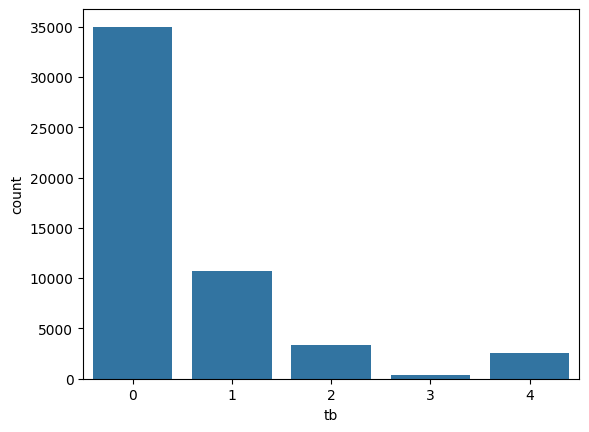

In [13]:
sns.countplot(train_data, x = "tb")

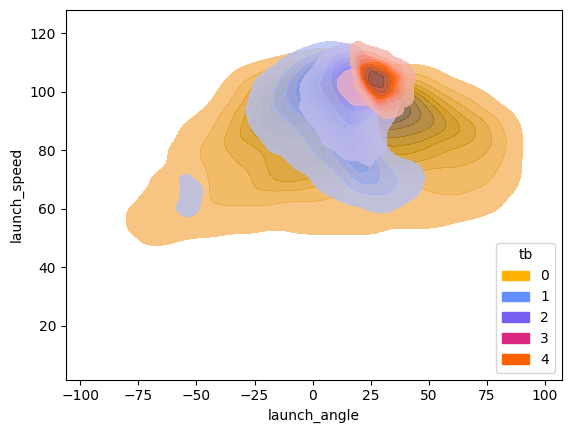

In [126]:
colour_palette = ['#FFB000','#648FFF','#785EF0',
                  '#DC267F','#FE6100','#3D1EB2',
                  '#894D80','#16AA02','#B5592B',
                  '#A3C1ED']
custom_palette = {0: colour_palette[0], 1: colour_palette[1], 2: colour_palette[2], 3: colour_palette[3], 4: colour_palette[4]}

ax = sns.kdeplot(data = train_data, x = "launch_angle", y = "launch_speed", 
                     hue = "tb", fill = True, palette = custom_palette, alpha = 0.8)
sns.move_legend(ax, "lower right")

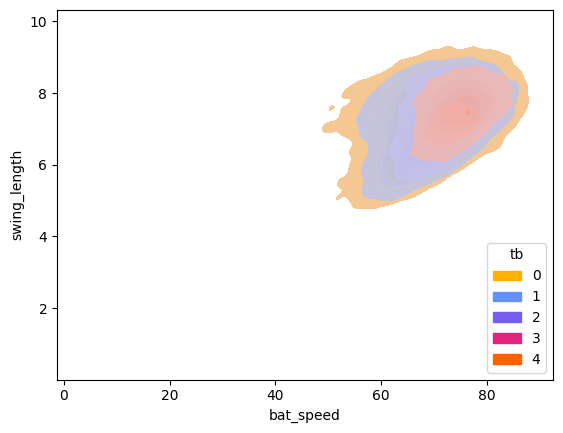

In [127]:
ax = sns.kdeplot(data = train_data, x = "bat_speed", y = "swing_length", hue = "tb", fill = True, palette = custom_palette, alpha = 0.8)
sns.move_legend(ax, "lower right")

### Model Training

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, RocCurveDisplay, roc_auc_score, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### Create Training and Testing Data

In [15]:
target = 'tb'
seed = 1126

x = train_data.loc[:, features].values
y = train_data[target].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = seed)

In [16]:
print(len(y_train))
print(len(y_test))

46710
5190


### Random Forest

In [43]:
rf_model = RandomForestClassifier(max_depth = 8, n_estimators = 200, random_state = seed)

In [44]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=1126)

In [45]:
y_train_pred = rf_model.predict(x_train)
y_train_pred_prob = rf_model.predict_proba(x_train)
y_test_pred = rf_model.predict(x_test)
y_test_pred_prob = rf_model.predict_proba(x_test)

In [46]:
classification_rep = classification_report(y_train, y_train_pred, zero_division = 1)

print("\nClassification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     31451
           1       0.66      0.51      0.58      9653
           2       0.56      0.11      0.19      2995
           3       1.00      0.00      0.00       295
           4       0.75      0.72      0.73      2316

    accuracy                           0.78     46710
   macro avg       0.76      0.46      0.47     46710
weighted avg       0.76      0.78      0.75     46710



In [47]:
print(roc_auc_score(y_train, y_train_pred_prob, multi_class = 'ovr'))

0.9054593734138869


In [48]:
classification_rep = classification_report(y_test, y_test_pred, zero_division = 1)

print("\nClassification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.86      3537
           1       0.62      0.50      0.55      1026
           2       0.44      0.07      0.13       354
           3       1.00      0.00      0.00        31
           4       0.69      0.69      0.69       242

    accuracy                           0.77      5190
   macro avg       0.71      0.44      0.45      5190
weighted avg       0.74      0.77      0.74      5190



In [49]:
print(roc_auc_score(y_test, y_test_pred_prob, multi_class = 'ovr'))

0.8769515359352044


### SVM

In [50]:
svm = SVC(probability = True, random_state = seed)

In [51]:
svm.fit(x_train, y_train)

SVC(probability=True, random_state=1126)

In [52]:
y_train_pred = svm.predict(x_train)
y_train_pred_prob = svm.predict_proba(x_train)
y_test_pred = svm.predict(x_test)
y_test_pred_prob = svm.predict_proba(x_test)

In [53]:
classification_rep = classification_report(y_train, y_train_pred, zero_division = 1)
auc = roc_auc_score(y_train, y_train_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.99      0.82     31451
           1       0.71      0.00      0.00      9653
           2       1.00      0.00      0.00      2995
           3       1.00      0.00      0.00       295
           4       0.75      0.64      0.69      2316

    accuracy                           0.70     46710
   macro avg       0.83      0.33      0.30     46710
weighted avg       0.72      0.70      0.59     46710


AUC score: 0.8591640016151233


In [54]:
classification_rep = classification_report(y_test, y_test_pred, zero_division = 1)
auc = roc_auc_score(y_test, y_test_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.99      0.82      3537
           1       0.50      0.00      0.00      1026
           2       1.00      0.00      0.00       354
           3       1.00      0.00      0.00        31
           4       0.69      0.63      0.66       242

    accuracy                           0.70      5190
   macro avg       0.78      0.32      0.30      5190
weighted avg       0.68      0.70      0.59      5190


AUC score: 0.8487959005897006


### XGBoost

In [26]:
xgb = XGBClassifier(random_state = seed, learning_rate = 0.1, n_estimators = 100)

In [27]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [28]:
y_train_pred = xgb.predict(x_train)
y_train_pred_prob = xgb.predict_proba(x_train)
y_test_pred = xgb.predict(x_test)
y_test_pred_prob = xgb.predict_proba(x_test)

In [29]:
classification_rep = classification_report(y_train, y_train_pred, zero_division = 1)
auc = roc_auc_score(y_train, y_train_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88     31451
           1       0.67      0.61      0.64      9653
           2       0.51      0.18      0.27      2995
           3       1.00      0.01      0.02       295
           4       0.75      0.75      0.75      2316

    accuracy                           0.79     46710
   macro avg       0.75      0.50      0.51     46710
weighted avg       0.78      0.79      0.78     46710


AUC score: 0.9262225000624301


In [30]:
classification_rep = classification_report(y_test, y_test_pred, zero_division = 1)
auc = roc_auc_score(y_test, y_test_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      3537
           1       0.63      0.58      0.60      1026
           2       0.48      0.18      0.26       354
           3       1.00      0.00      0.00        31
           4       0.70      0.72      0.71       242

    accuracy                           0.78      5190
   macro avg       0.73      0.48      0.49      5190
weighted avg       0.76      0.78      0.76      5190


AUC score: 0.8849053760223186


### LightGBM

In [31]:
lgb = LGBMClassifier(random_state = seed, learning_rate = 0.05, max_depth = 6)

In [32]:
lgb.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 46710, number of used features: 5
[LightGBM] [Info] Start training from score -0.395527
[LightGBM] [Info] Start training from score -1.576690
[LightGBM] [Info] Start training from score -2.747014
[LightGBM] [Info] Start training from score -5.064738
[LightGBM] [Info] Start training from score -3.004117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

LGBMClassifier(learning_rate=0.05, max_depth=6, random_state=1126)

In [33]:
y_train_pred = lgb.predict(x_train)
y_train_pred_prob = lgb.predict_proba(x_train)
y_test_pred = lgb.predict(x_test)
y_test_pred_prob = lgb.predict_proba(x_test)

c:\Users\citioplab\works\codes\baseball_projects\baseball_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\citioplab\works\codes\baseball_projects\baseball_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\citioplab\works\codes\baseball_projects\baseball_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\citioplab\works\codes\baseball_projects\baseball_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [34]:
classification_rep = classification_report(y_train, y_train_pred, zero_division = 1)
auc = roc_auc_score(y_train, y_train_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87     31451
           1       0.66      0.59      0.62      9653
           2       0.50      0.17      0.26      2995
           3       1.00      0.04      0.08       295
           4       0.75      0.75      0.75      2316

    accuracy                           0.79     46710
   macro avg       0.75      0.50      0.52     46710
weighted avg       0.77      0.79      0.77     46710


AUC score: 0.9257212579227451


In [35]:
classification_rep = classification_report(y_test, y_test_pred, zero_division = 1)
auc = roc_auc_score(y_test, y_test_pred_prob, multi_class = 'ovr')

print("\nClassification Report:\n", classification_rep)
print(f'\nAUC score: {auc}')


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      3537
           1       0.62      0.56      0.59      1026
           2       0.47      0.16      0.23       354
           3       1.00      0.00      0.00        31
           4       0.70      0.72      0.71       242

    accuracy                           0.78      5190
   macro avg       0.72      0.47      0.48      5190
weighted avg       0.76      0.78      0.76      5190


AUC score: 0.8832977279558868


##### After adding sprint speed as a feature, XGB and LightGBM performed on testing data. However, I still choose random forest as my model for comparison.

### Count My xwOBA

In [145]:
tmp = [0] + woba_values_2024[2:]
processed_data_2024.loc[processed_data_2024['description'] == 'hit_into_play', 'woba_pred'] = [np.sum(x) for x in rf_model.predict_proba(processed_data_2024.loc[processed_data_2024['description'] == 'hit_into_play', features].values) * tmp]

In [146]:
processed_data_2024.loc[processed_data_2024['events'] == 'walk','woba_pred'] = 0.689
processed_data_2024.loc[processed_data_2024['events'] == 'hit_by_pitch','woba_pred'] = 0.720

In [147]:
processed_data_2024.loc[processed_data_2024['woba_pred'].isna(), 'events'].value_counts()

Series([], Name: count, dtype: int64)

In [148]:
processed_data_2024 = processed_data_2024.fillna(value = {'woba_pred': 0})

In [149]:
batter_df_2024 = processed_data_2024.groupby(['batter']).agg(woba_pred = ('woba_pred', 'mean'))
batter_df_2024.head()

,woba_pred
batter,
444482,0.318360
453568,0.305216
455117,0.239260
456781,0.307198
457705,0.333710


In [150]:
batter_df_2024 = batter_df_2024.reset_index()

In [151]:
excepted_data_2024 = pd.read_csv('./2024_excepted_data.csv')
excepted_data_2024.head()

,"last_name, first_name",player_id,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff
0,"Duran, Jarren",680776,2024,735,515,0.285,0.271,0.014,0.492,0.448,0.044,0.357,0.338,0.019
1,"Ohtani, Shohei",660271,2024,731,479,0.310,0.314,-0.004,0.646,0.660,-0.014,0.431,0.442,-0.011
2,"Henderson, Gunnar",683002,2024,719,475,0.281,0.283,-0.002,0.529,0.492,0.037,0.381,0.374,0.007
3,"Semien, Marcus",543760,2024,718,546,0.237,0.251,-0.014,0.391,0.391,0.000,0.306,0.313,-0.007
4,"Soto, Juan",665742,2024,713,461,0.288,0.316,-0.028,0.569,0.646,-0.077,0.421,0.462,-0.041


In [152]:
batter_df_2024_merged = batter_df_2024.merge(excepted_data_2024, left_on = 'batter', right_on = 'player_id')
batter_df_2024_merged = batter_df_2024_merged.loc[:, ['player_id', 'last_name, first_name', 'woba', 'est_woba', 'woba_pred', 'pa']]
batter_df_2024_merged = batter_df_2024_merged.loc[batter_df_2024_merged['pa'] > 100, :]

In [153]:
batter_df_2024_merged.sort_values('woba_pred', ascending = False)

,player_id,"last_name, first_name",woba,est_woba,woba_pred,pa
69,592450,"Judge, Aaron",0.476,0.479,0.481414,704
305,665742,"Soto, Juan",0.421,0.462,0.464303,713
241,660271,"Ohtani, Shohei",0.431,0.442,0.439176,731
302,665489,"Guerrero Jr., Vladimir",0.398,0.408,0.427262,697
404,670541,"Alvarez, Yordan",0.402,0.411,0.416977,635
...,...,...,...,...,...,...
43,547989,"Abreu, José",0.164,0.198,0.239036,120
388,669397,"Allen, Nick",0.207,0.220,0.238123,105
222,656577,"Jackson, Alex",0.200,0.223,0.233101,155
496,680779,"Davis, Henry",0.213,0.226,0.225284,122


Text(0, 0.5, 'xwOBA')

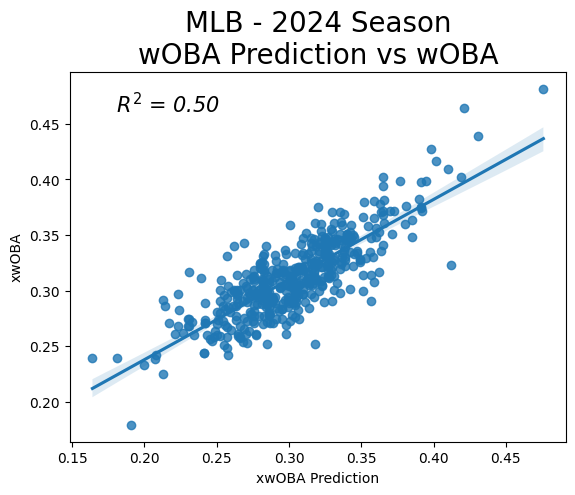

In [154]:
sns.regplot(data = batter_df_2024_merged, x = 'woba', y = 'woba_pred')
plt.text(x = 0.18, y = 0.46, s = r"$R^{2}$" + f" = {r2_score(batter_df_2024_merged['woba_pred'], batter_df_2024_merged['woba']):.2f}", fontsize = '15', fontstyle = 'oblique')

plt.title('MLB - 2024 Season\nwOBA Prediction vs wOBA', fontsize = 20)
plt.xlabel('xwOBA Prediction')
plt.ylabel('xwOBA')

Text(0, 0.5, 'xwOBA (Savant)')

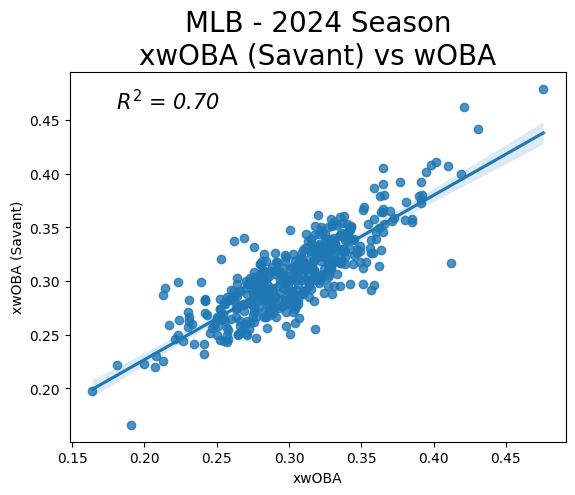

In [155]:
sns.regplot(data = batter_df_2024_merged, x = 'woba', y = 'est_woba')
plt.text(x = 0.18, y = 0.46, s = r"$R^{2}$" + f" = {r2_score(batter_df_2024_merged['woba'], batter_df_2024_merged['est_woba']):.2f}", fontsize = '15', fontstyle = 'oblique')

plt.title('MLB - 2024 Season\nxwOBA (Savant) vs wOBA', fontsize = 20)
plt.xlabel('xwOBA')
plt.ylabel('xwOBA (Savant)')

Text(0, 0.5, 'xwOBA (Savant)')

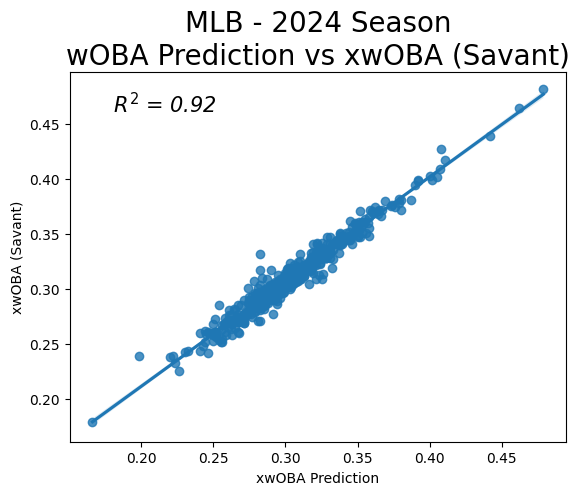

In [156]:
sns.regplot(data = batter_df_2024_merged, x = 'est_woba', y = 'woba_pred')
plt.text(x = 0.18, y = 0.46, s = r"$R^{2}$" + f" = {r2_score(batter_df_2024_merged['woba_pred'], batter_df_2024_merged['est_woba']):.2f}", fontsize = '15', fontstyle = 'oblique')

plt.title('MLB - 2024 Season\nwOBA Prediction vs xwOBA (Savant)', fontsize = 20)
plt.xlabel('xwOBA Prediction')
plt.ylabel('xwOBA (Savant)')

##### After adding sprint speed as a feature, my model diverges from wOBA and xwOBA. This is not a good sign.

In [157]:
def add_stat_to_label(data, label):
    """add mean and std to label"""
    return label+f"\n$\mu={round(data.mean(), 3)}$\n$\sigma={round(data.std(), 3)}$"

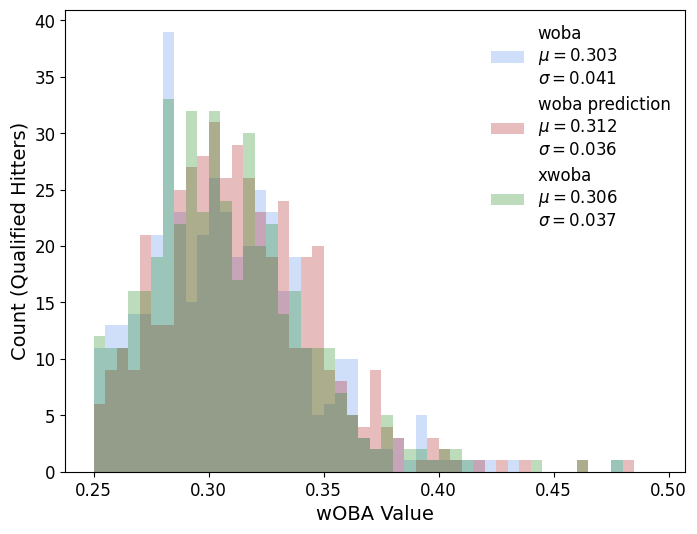

In [158]:
fig = plt.figure(figsize=(8,6))

bins = np.arange(0.25, 0.5, 0.005)

plt.hist(batter_df_2024_merged["woba"], bins = bins,
           color = "cornflowerblue", alpha = 0.3, label = add_stat_to_label(batter_df_2024_merged["woba"], 'woba'))
plt.hist(batter_df_2024_merged["woba_pred"], bins = bins,
           color = "firebrick", alpha = 0.3, label = add_stat_to_label(batter_df_2024_merged["woba_pred"], 'woba prediction'))
plt.hist(batter_df_2024_merged["est_woba"], bins = bins,
           color = "forestgreen", alpha = 0.3, label = add_stat_to_label(batter_df_2024_merged["est_woba"], 'xwoba'))
plt.legend(frameon = False,fontsize = 12)

plt.xlabel("wOBA Value",fontsize = 14)
plt.ylabel("Count (Qualified Hitters)", fontsize = 14)
plt.tick_params(labelsize = 12)

##### According to the chart, my model tends to predict wOBA higher than the Statcast system does.